In [272]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
# 1: Load and Inspect the Data #

In [137]:
raw_data = pd.read_csv(r"C:\Users\Pooria\Downloads\titanic\train.csv")

raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [138]:
raw_data.info()
raw_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [130]:
# 2: Identify Problems #

In [139]:
print(raw_data.isna().sum())
print("_______")
print(raw_data.duplicated().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
_______
0


In [131]:
# 3: Handle Missing Values #

In [140]:
raw_data["Age"] = raw_data["Age"].fillna(raw_data["Age"].median())

In [ ]:
raw_data["Embarked"] = raw_data["Embarked"].fillna(raw_data["Embarked"].mode()[0])

In [142]:
raw_data = raw_data.drop(columns=["Cabin"])

In [143]:
print(raw_data.isna().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [132]:
# 4: Feature Engineering #

In [ ]:
raw_data["Family_Size"] = raw_data["SibSp"] + raw_data["Parch"] + 1
print(raw_data[["SibSp", "Parch", "Family_Size"]].head())

   SibSp  Parch  Family_Size
0      1      0            2
1      1      0            2
2      0      0            1
3      1      0            2
4      0      0            1


In [ ]:
raw_data["Is_Alone"] = (raw_data["Family_Size"] == 1)
print(raw_data[["Family_Size", "Is_Alone"]].head())

   Family_Size  Is_Alone
0            2     False
1            2     False
2            1      True
3            2     False
4            1      True


In [146]:
raw_data["Title"] = raw_data["Name"].str.extract(r",\s*([A-Za-z]+)\.")  # gets Mr, Mrs, Miss, etc.
raw_data["Title"].value_counts().head()

Title
Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: count, dtype: int64

In [147]:
title_map = {
    "Mlle":"Miss", "Ms":"Miss", "Mme":"Miss",
    "Lady":"Royal", "Countess":"Royal", "Sir":"Royal",
    "Don":"Royal", "Dona":"Royal", "Jonkheer":"Royal",
    "Col":"Officer", "Major":"Officer", "Capt":"Officer", "Dr":"Officer", "Rev":"Officer" 
}
raw_data["Title"] = raw_data["Title"].replace(title_map)

common = {"Mr", "Mrs", "Miss", "Master", "Royal"}
raw_data["Title"] = raw_data["Title"].where(raw_data["Title"].isin(common), other="Other")

print(raw_data["Title"].value_counts())

Title
Mr        517
Miss      186
Mrs       125
Master     40
Other      19
Royal       4
Name: count, dtype: int64


In [148]:
print(raw_data[["Age", "Family_Size", "Is_Alone", "Title"]].head())

    Age  Family_Size  Is_Alone Title
0  22.0            2     False    Mr
1  38.0            2     False   Mrs
2  26.0            1      True  Miss
3  35.0            2     False   Mrs
4  35.0            1      True    Mr


In [133]:
# 5: Convert Data Types & Encode #

In [165]:
encoded_raw_data = pd.get_dummies(raw_data, columns=["Sex", "Embarked", "Title"], drop_first=True)
encoded_raw_data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Family_Size,Is_Alone,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,2,False,True,False,True,False,True,False,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,2,False,False,False,False,False,False,True,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,True,False,False,True,True,False,False,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,2,False,False,False,True,False,False,True,False,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,True,True,False,True,False,True,False,False,False


In [ ]:
# Survival Rate by:
# [Sex, Pclass, Embarked, Is_Alone, Title]
print("By Sex:\n", raw_data.groupby("Sex")["Survived"].mean().round(3))
print("\nBy Pclass\n", raw_data.groupby("Pclass")["Survived"].mean().round(3))
print("\nBy Embarked\n", raw_data.groupby("Embarked")["Survived"].mean().round(3))
print("\nBy Is_Alone\n", raw_data.groupby("Is_Alone")["Survived"].mean().round(3))
print("\nBy Title\n", raw_data.groupby("Title")["Survived"].mean().round(3))

By Sex:
 Sex
female    0.742
male      0.189
Name: Survived, dtype: float64

By Pclass
 Pclass
1    0.630
2    0.473
3    0.242
Name: Survived, dtype: float64

By Embarked
 Embarked
C    0.554
Q    0.390
S    0.339
Name: Survived, dtype: float64

By Is_Alone
 Is_Alone
False    0.506
True     0.304
Name: Survived, dtype: float64

By Title
 Title
Master    0.575
Miss      0.704
Mr        0.157
Mrs       0.792
Other     0.316
Royal     0.500
Name: Survived, dtype: float64


In [ ]:
# 6. Data Visualization #

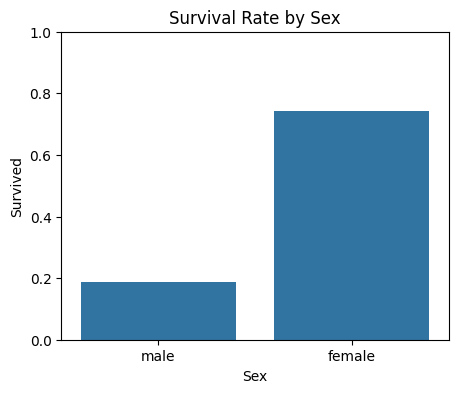

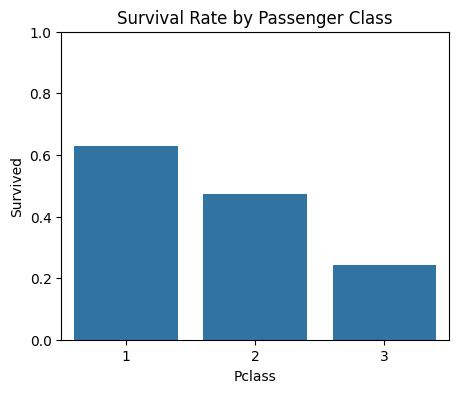

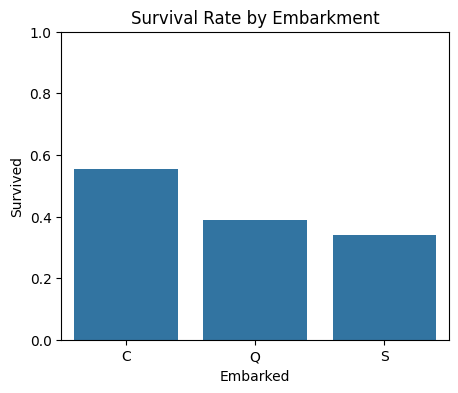

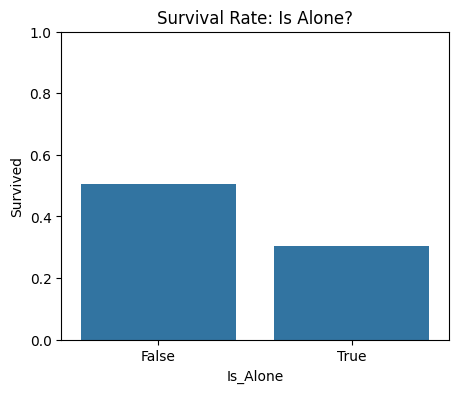

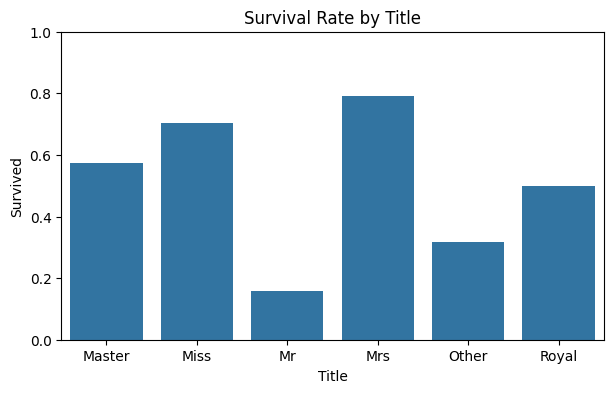

In [173]:
# Survival by Sex
plt.figure(figsize=(5,4))
sns.barplot(data=raw_data, x="Sex", y="Survived", estimator="mean", errorbar=None)
plt.title("Survival Rate by Sex")
plt.ylim(0,1)
plt.show()

# Survival by Pclass
plt.figure(figsize=(5,4))
sns.barplot(data=raw_data, x="Pclass", y="Survived", estimator="mean", errorbar=None)
plt.title("Survival Rate by Passenger Class")
plt.ylim(0,1)
plt.show()

# Survival by Embarked
plt.figure(figsize=(5,4))
sns.barplot(data=raw_data, x="Embarked", y="Survived", estimator="mean", errorbar=None,
            order=sorted(raw_data["Embarked"].dropna().unique()))
plt.title("Survival Rate by Embarkment")
plt.ylim(0,1)
plt.show()

# Survival by Is_Alone
plt.figure(figsize=(5,4))
sns.barplot(data=raw_data, x="IsAlone" if "IsAlone" in raw_data.columns else "Is_Alone",
            y="Survived", estimator="mean", errorbar=None)
plt.title("Survival Rate: Is Alone?")
plt.ylim(0,1)
plt.show()

# Survival by Title
plt.figure(figsize=(7,4))
sns.barplot(data=raw_data, x="Title", y="Survived", estimator="mean", errorbar=None,
            order=sorted(raw_data["Title"].unique()))
plt.title("Survival Rate by Title")
plt.ylim(0,1)
plt.show()

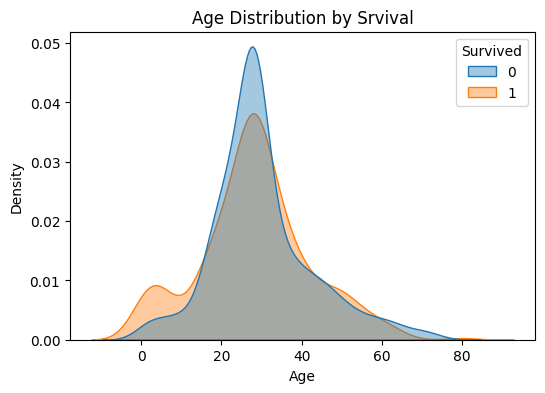

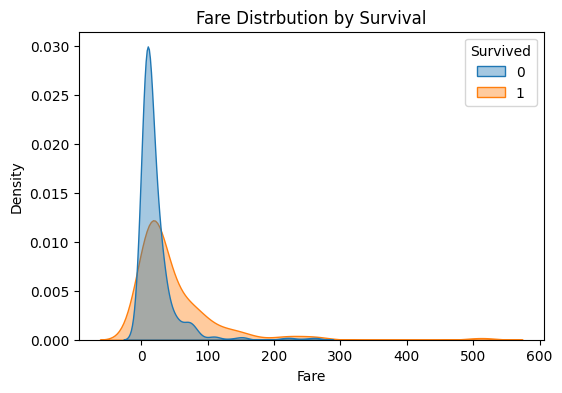

In [174]:
# Age distribution by Survived
plt.figure(figsize=(6,4))
sns.kdeplot(data=raw_data, x="Age", hue="Survived", fill=True, common_norm=False, alpha=0.4)
plt.title("Age Distribution by Srvival")
plt.show()

# Fare distribution by Survived
plt.figure(figsize=(6,4))
sns.kdeplot(data=raw_data, x="Fare", hue="Survived", fill=True, common_norm=False, alpha=0.4)
plt.title("Fare Distrbution by Survival")
plt.show()

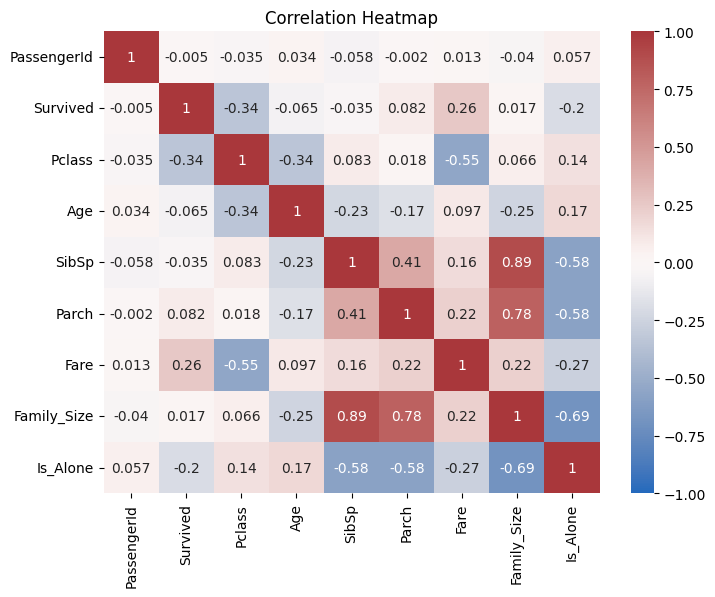

In [175]:
num_cols = raw_data.select_dtypes(include=["number", "bool"]).copy()

for i in num_cols.columns:
    if num_cols[i].dtype == bool:
        num_cols[i] = num_cols[i].astype(int)

plt.figure(figsize=(8,6))
sns.heatmap(num_cols.corr().round(3), annot=True, vmin=-1, vmax= 1, cmap="vlag")
plt.title("Correlation Heatmap")
plt.show()

In [176]:
# Table of Survival by [Sex , Pclass]
summary = raw_data.pivot_table(values="Survived", index="Sex", columns="Pclass", aggfunc="mean").round(3)
print(summary)

Pclass      1      2      3
Sex                        
female  0.968  0.921  0.500
male    0.369  0.157  0.135


In [134]:
# 7. Model Preparation #
#Select features for modeling
#Split data into training and validation sets
#Scale numeric features if needed

In [199]:
model_df = encoded_raw_data.copy()

In [ ]:
features = [
    "Pclass", "Age", "Fare", "Sex_male",
    "Embarked_Q", "Embarked_S",
    "Is_Alone",
    "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Title_Royal"
]

x = model_df[features]
y = encoded_raw_data["Survived"]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# 8. raining a Simple Model #

In [197]:
# Initialize model
model = LogisticRegression(max_iter=1000)
# Fit Model
model.fit(x_train, y_train)
# Predict on Validation set
y_pred = model.predict(x_val)

print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

0.7932960893854749
[[86 19]
 [18 56]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       105
           1       0.75      0.76      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



In [ ]:
# 9. Advanced Models Training #

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "SVC": SVC(kernel="rbf", C=1.0, gamma="scale") # Support Vector Classifier
}

In [213]:
results = {}

for name, model in models.items():
    model.fit(x_train, y_train)

    y_pred = model.predict(x_val)

    acc = accuracy_score(y_val, y_pred)
    results[name] = round(acc, 4)
    print(f"{name}: {acc}")

Logistic Regression: 0.7932960893854749
Random Forest: 0.8324022346368715
Decision Tree: 0.770949720670391
KNN: 0.7150837988826816
SVC: 0.6536312849162011


In [214]:
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"]).sort_values(by="Accuracy", ascending=False)
print(results_df) 

                 Model  Accuracy
1        Random Forest    0.8324
0  Logistic Regression    0.7933
2        Decision Tree    0.7709
3                  KNN    0.7151
4                  SVC    0.6536


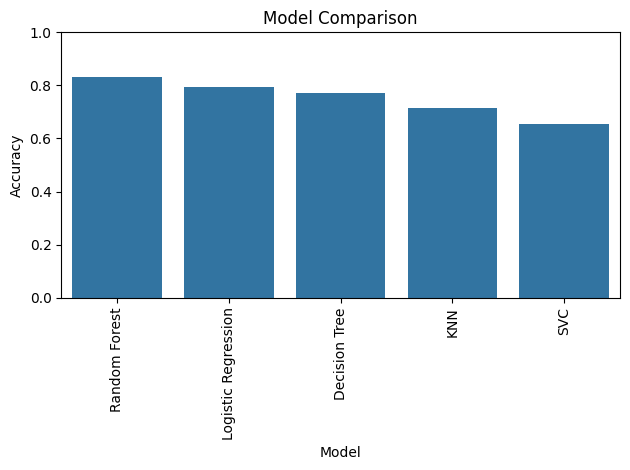

In [220]:
sns.barplot(data=results_df, x="Model", y="Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [244]:
test_data = pd.read_csv(r"C:\Users\Pooria\Downloads\titanic\test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [245]:
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].median())
test_data["Embarked"] = test_data["Embarked"].fillna(test_data["Embarked"].mode()[0])

In [246]:
test_data = test_data.drop(columns=["Cabin"])
print(test_data.isna().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64


In [248]:
test_data["Family_Size"] = test_data["SibSp"] + test_data["Parch"] + 1
print(test_data[["SibSp", "Parch", "Family_Size"]].head())

   SibSp  Parch  Family_Size
0      0      0            1
1      1      0            2
2      0      0            1
3      0      0            1
4      1      1            3


In [250]:
test_data["Is_Alone"] = (test_data["Family_Size"] == 1)
print(test_data[["Family_Size", "Is_Alone"]].head())

   Family_Size  Is_Alone
0            1      True
1            2     False
2            1      True
3            1      True
4            3     False


In [249]:
test_data["Title"] = test_data["Name"].str.extract(r",\s*([A-Za-z]+)\.")
test_data["Title"].value_counts().head()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Name: count, dtype: int64

In [255]:
title_map = {
    "Mlle":"Miss", "Ms":"Miss", "Mme":"Miss",
    "Lady":"Royal", "Countess":"Royal", "Sir":"Royal",
    "Don":"Royal", "Dona":"Royal", "Jonkheer":"Royal",
    "Col":"Officer", "Major":"Officer", "Capt":"Officer", "Dr":"Officer", "Rev":"Officer" 
}
test_data["Title"] = test_data["Title"].replace(title_map)

common = {"Mr", "Mrs", "Miss", "Master", "Royal"}
test_data["Title"] = test_data["Title"].where(test_data["Title"].isin(common), other="Other")

print(test_data["Title"].value_counts())

Title
Mr        240
Miss       79
Mrs        72
Master     21
Other       5
Royal       1
Name: count, dtype: int64


In [257]:
encoded_test_data = pd.get_dummies(test_data, columns=["Sex", "Embarked", "Title"])
encoded_test_data.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Family_Size,Is_Alone,...,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Title_Royal
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,1,True,...,True,False,True,False,False,False,True,False,False,False
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,2,False,...,False,False,False,True,False,False,False,True,False,False
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,1,True,...,True,False,True,False,False,False,True,False,False,False
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,1,True,...,True,False,False,True,False,False,True,False,False,False
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,3,False,...,False,False,False,True,False,False,False,True,False,False


In [262]:
features = [
    "Pclass", "Age", "Fare", "Sex_male",
    "Embarked_Q", "Embarked_S",
    "Is_Alone",
    "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Other", "Title_Royal"
]

for col in features:
    if col not in encoded_test_data.columns:
        encoded_test_data[col] = 0

X_test = encoded_test_data[features]

In [264]:
print(X_test.isna().sum())

Pclass         0
Age            0
Fare           1
Sex_male       0
Embarked_Q     0
Embarked_S     0
Is_Alone       0
Title_Miss     0
Title_Mr       0
Title_Mrs      0
Title_Other    0
Title_Royal    0
dtype: int64


In [265]:
X_test["Fare"] = X_test["Fare"].fillna(X_test["Fare"].median())

C:\Users\Pooria\AppData\Local\Temp\ipykernel_19396\1988284452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Fare"] = X_test["Fare"].fillna(X_test["Fare"].median())


In [ ]:
X_test = X_test.fillna(0)
print(X_test.isna().sum().sum()) 

0


In [274]:
test_predictions = model.predict(X_test)

In [287]:
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": test_predictions.astype(int)
})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [288]:
# Check class balance
print(submission["Survived"].value_counts())

# Make sure PassengerId count matches
print(len(submission), len(test_data["PassengerId"]))

## 3) Save the CSV for Kaggle
submission.to_csv("titanic_submission.csv", index=False)
print("Saved: titanic_submission.csv")

Survived
0    351
1     67
Name: count, dtype: int64
418 418
Saved: titanic_submission.csv
